### Import dependencies

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import time
import datetime
import numpy as np

from ignite.metrics.recall import Recall
from ignite.engine import *

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Dataloader

In [8]:
class SER_Dataset(Dataset):
    def __init__(self, data_path):
        """
        Аргументы:
            data_path -- путь к папке извлеченными признаками
        """
        
        self._ids = list([])    # speaker IDs

        X = pd.read_csv("../../data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv", index_col=0)
        y = pd.read_csv('../../data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv', index_col=0)
        ID= pd.read_csv('../../data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv', index_col=0)

        # Convert features and labels to numpy arrays
        X = X.values
        y.replace({'neutral':0, 'calm':1, 'happy':2, 'sad':3, 'angry':4, 'fear':5, 'disgust':6, 'surprised':7}, inplace=True)
        y = torch.tensor(y.values)
        self.y = torch.nn.functional.one_hot(y, num_classes=8)
        self.y = self.y.squeeze(dim=1)
        self.y = self.y.float()
        self.X = torch.from_numpy(X).float()

        self.folds = list(([2, 5, 14, 15, 16], # 0
                           [3, 6, 7, 13, 18], # 1
                           [10, 11, 12, 19, 20], # 2
                           [8, 17, 21, 23, 24], # 3
                           [1, 4, 9, 22]))     # 4

        self.folds_val = list(([3, 6],
                              [10, 11],
                              [8, 17],
                              [1, 14],
                              [2, 5]))

        self.X_ids = list(np.array(ID.values).squeeze())        
       
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # self.X = self.X.to(device)
        # self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            # print(self.X_ids[i])
            # print(self.folds[fold_num])
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

In [9]:
## test dataloader
SER_data_set = SER_Dataset('')
# print(len(SER_data_set))
# X,y = SER_data_set[2]
# print(X)
# print(y)
# ids_train,ids_val, ids_test = SER_data_set.get_kth_fold_inds(4)

# Linear NN

In [10]:
class SER_one_layer_NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SER_one_layer_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)        
        self.num_classes = num_classes

        torch.manual_seed(702)
        nn.init.xavier_uniform_(self.fc1.weight)        


    def forward(self, x):
        # Multiply input by weights and add biases
        linear_output = self.fc1(x)
        SER_out = torch.nn.functional.softmax(linear_output, dim=0)
        return SER_out

    # def train_model(self, input_data, target_labels, num_epochs=1000, learning_rate=0.01):
    #     # Define the loss function
    #     criterion = nn.CrossEntropyLoss()
    #     # Define the optimizer
    #     optimizer = optim.SGD(self.parameters(), lr=learning_rate)

    #     for epoch in range(num_epochs):
    #         # Forward pass
    #         outputs = self(input_data)

    #         # Compute the loss
    #         loss = criterion(outputs, target_labels)

    #         # Backward pass and optimization
    #         optimizer.zero_grad()
    #         loss.backward()
    #         optimizer.step()

    #         # Print the loss every few epochs
    #         if epoch % 10 == 0:
    #             print(f"Epoch {epoch}: Loss {loss.item()}")

    # def predict(self, input_data):
    #     # Forward pass to get the output logits
    #     logits = self(input_data)
    #     # Apply softmax to get probabilities
    #     probabilities = F.softmax(logits, dim=1)
    #     # Get the class label with highest probability
    #     predicted_labels = torch.argmax(probabilities, dim=1)
    #     return predicted_labels


    # def estimate(self, y_true, y_pred):
    #   """
    #   calculates the unweighted average recall across all the classes present
    #   in the true labels (y_true)
    #   and predicted labels (y_pred) using the confusion matrix.
    #   """
    #   cm = confusion_matrix(y_true, y_pred)
    #   num_classes = len(cm)
    #   recalls = []
    #   for i in range(self.num_classes):
    #       true_positives = cm[i, i]
    #       actual_positives = sum(cm[i, :])
    #       recall = true_positives / actual_positives
    #       recalls.append(recall)
    #   average_recall = sum(recalls) / num_classes
    #   return average_recall

## Model test

In [11]:
X,y = SER_data_set[2]
model = SER_one_layer_NN(len(X), y.shape[0])
y_out = model(X)

Epoch 1: 100%|██████████| 204/204 [00:00<00:00, 814.58it/s]


2024-03-17 17:56:22.514139 Epoch 1, Train loss 2.016, Val loss 1.937, UAR_val = 0.359


Epoch 2: 100%|██████████| 204/204 [00:00<00:00, 767.16it/s]


2024-03-17 17:56:22.805046 Epoch 2, Train loss 1.946, Val loss 1.887, UAR_val = 0.391


Epoch 3: 100%|██████████| 204/204 [00:00<00:00, 767.16it/s]


2024-03-17 17:56:23.095952 Epoch 3, Train loss 1.903, Val loss 1.862, UAR_val = 0.469


Epoch 4: 100%|██████████| 204/204 [00:00<00:00, 694.84it/s]


2024-03-17 17:56:23.414537 Epoch 4, Train loss 1.850, Val loss 1.854, UAR_val = 0.461


Epoch 5: 100%|██████████| 204/204 [00:00<00:00, 793.62it/s]


2024-03-17 17:56:23.695577 Epoch 5, Train loss 1.850, Val loss 1.837, UAR_val = 0.445


Epoch 6: 100%|██████████| 204/204 [00:00<00:00, 800.26it/s]


2024-03-17 17:56:23.976487 Epoch 6, Train loss 1.830, Val loss 1.813, UAR_val = 0.531


Epoch 7: 100%|██████████| 204/204 [00:00<00:00, 738.69it/s]


2024-03-17 17:56:24.276645 Epoch 7, Train loss 1.809, Val loss 1.803, UAR_val = 0.531


Epoch 8: 100%|██████████| 204/204 [00:00<00:00, 758.61it/s]


2024-03-17 17:56:24.570551 Epoch 8, Train loss 1.808, Val loss 1.794, UAR_val = 0.539


Epoch 9: 100%|██████████| 204/204 [00:00<00:00, 754.54it/s]


2024-03-17 17:56:24.865910 Epoch 9, Train loss 1.798, Val loss 1.801, UAR_val = 0.531


Epoch 10: 100%|██████████| 204/204 [00:00<00:00, 635.72it/s]


2024-03-17 17:56:25.226794 Epoch 10, Train loss 1.781, Val loss 1.801, UAR_val = 0.500


Epoch 11: 100%|██████████| 204/204 [00:00<00:00, 755.49it/s]


2024-03-17 17:56:25.519809 Epoch 11, Train loss 1.783, Val loss 1.799, UAR_val = 0.562


Epoch 12: 100%|██████████| 204/204 [00:00<00:00, 610.97it/s]


2024-03-17 17:56:25.882694 Epoch 12, Train loss 1.757, Val loss 1.789, UAR_val = 0.578


Epoch 13: 100%|██████████| 204/204 [00:00<00:00, 787.55it/s]


2024-03-17 17:56:26.164715 Epoch 13, Train loss 1.767, Val loss 1.795, UAR_val = 0.578


Epoch 14: 100%|██████████| 204/204 [00:00<00:00, 728.81it/s]


2024-03-17 17:56:26.469618 Epoch 14, Train loss 1.749, Val loss 1.793, UAR_val = 0.555


Epoch 15: 100%|██████████| 204/204 [00:00<00:00, 800.39it/s]


2024-03-17 17:56:26.748488 Epoch 15, Train loss 1.737, Val loss 1.786, UAR_val = 0.578


Epoch 16: 100%|██████████| 204/204 [00:00<00:00, 800.26it/s]


2024-03-17 17:56:27.033396 Epoch 16, Train loss 1.752, Val loss 1.787, UAR_val = 0.586


Epoch 17: 100%|██████████| 204/204 [00:00<00:00, 809.78it/s]


2024-03-17 17:56:27.309308 Epoch 17, Train loss 1.752, Val loss 1.788, UAR_val = 0.562


Epoch 18: 100%|██████████| 204/204 [00:00<00:00, 703.40it/s]


2024-03-17 17:56:27.628434 Epoch 18, Train loss 1.740, Val loss 1.785, UAR_val = 0.555


Epoch 19: 100%|██████████| 204/204 [00:00<00:00, 791.37it/s]


2024-03-17 17:56:27.911206 Epoch 19, Train loss 1.753, Val loss 1.780, UAR_val = 0.562


Epoch 20: 100%|██████████| 204/204 [00:00<00:00, 797.13it/s]


2024-03-17 17:56:28.191118 Epoch 20, Train loss 1.739, Val loss 1.772, UAR_val = 0.570


Text(0, 0.5, 'Ошибка обучения')

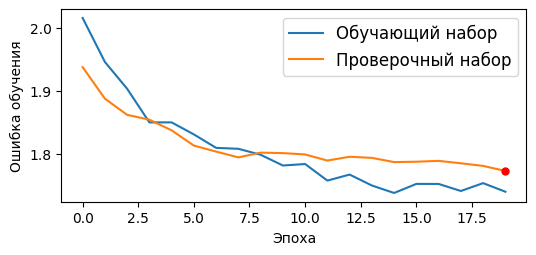

In [21]:
model = SER_one_layer_NN(306,8)
n_epochs = 20

optimizer = Adam(model.parameters(),lr=5e-4, weight_decay=1e-2) # weight_decay is L2 regularization
loss_fn = nn.CrossEntropyLoss()

SER_data_set = SER_Dataset('')

inds_train,inds_val,inds_test = SER_data_set.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(SER_data_set, inds_train)
val_set = torch.utils.data.dataset.Subset(SER_data_set, inds_val)
# test_set = torch.utils.data.dataset.Subset(SER_data_set, inds_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=5,shuffle=True)  # num_workers=2
val_loader = torch.utils.data.DataLoader(val_set, batch_size=5, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False) 

metric = Recall()
macro_metric = Recall(average=True)

metric.attach(default_evaluator, "recall")
macro_metric.attach(default_evaluator, "macro recall")


MODEL_PATH = "model_backup/model_nn.pt"
loss_train_history = np.ndarray((n_epochs))
loss_val_history = np.ndarray((n_epochs))
lrs = []
best_epoch = -1
loss_val_min = 100
for epoch in range(1,n_epochs+1):
    model.train()
    loss_train = 0.0
    for X, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:        
        outputs = model(X)
        outputs = outputs.squeeze(dim=1) # for batch train_loader
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    loss_train = loss_train / len(train_loader)

    # prediction on val set
    loss_val = 0.0
    TP_TN_sum = 0
    total = 0
    model.eval()
    val_pred = []
    val_true = []
    with torch.no_grad():
        for X, labels in val_loader:
            pred = model(X)
            pred = pred.squeeze(dim=1) # for batch train_loader

            loss = loss_fn(pred, labels)
            loss_val += loss.item()

            # _,pred = torch.max(pred, dim=1)
            _,labels = torch.max(labels, dim=1)

            val_pred.append(pred)
            val_true.append(labels)                        

        val_pred = torch.cat(val_pred)
        val_true = torch.cat(val_true)

        default_evaluator.terminate()
        state = default_evaluator.run([[val_pred, val_true]])
        # print(f"Recall: {state.metrics['recall']}")
        # print(f"Macro Recall: {state.metrics['macro recall']}")

        loss_val = loss_val / len(val_loader)

        loss_train_history[epoch-1] = loss_train
        loss_val_history[epoch-1] = loss_val

        if loss_val < loss_val_min:
            torch.save(model.state_dict(), MODEL_PATH)
            loss_val_min = loss_val
            best_epoch = epoch-1
        UAR = state.metrics['macro recall']
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train:.3f}, Val loss {loss_val:.3f}, UAR_val = {UAR:.3f}')

model.load_state_dict(torch.load(MODEL_PATH))

fig, ax = plt.subplots(figsize=(6,2.5))
plt.rcParams.update({'font.size': 12})
# plt.subplot(1,2,1)
plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
plt.plot(best_epoch,loss_val_min,color='red', marker='o', linewidth=1, markersize=5)
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Ошибка обучения')

# Train loop

In [ ]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):
    MODEL_PATH = "model_backup/model_nn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    best_epoch = -1
    loss_val_min = 100
    for epoch in range(1,n_epochs+1):
        model.train()
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)
            outputs = outputs.squeeze(dim=1) # for batch train_loader
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        loss_train = loss_train / len(train_loader)

        # prediction on val set
        loss_val = 0.0
        TP_TN_sum = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for spec, label in val_loader:
                spec = spec.float()
                pred = model(spec)
                pred = torch.squeeze(pred,1)

                loss = loss_fn(pred, label)
                loss_val += loss.item()

                _,pred = torch.max(pred, dim=1)
                _,label = torch.max(label, dim=1)

                total += len(label)

                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/total
        loss_val = loss_val / len(val_loader)

        loss_train_history[epoch-1] = loss_train
        loss_val_history[epoch-1] = loss_val

        if loss_val < loss_val_min:
            torch.save(model.state_dict(), MODEL_PATH)
            loss_val_min = loss_val
            best_epoch = epoch-1

        # if epoch==1 or epoch%2==0:
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train:.3f}, Val loss {loss_val:.3f}, Acc_val = {acc_val:.2f}')

        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()

    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.plot(best_epoch,loss_val_min,color='red', marker='o', linewidth=1, markersize=5)
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history,loss_val_min,best_epoch)

### Experiment

In [194]:
# Load data from CSV files using pandas
features_df = pd.read_csv('/content/feature_mfcc_34_delta_delta_nfft_8192.csv', index_col=0)
labels_df = pd.read_csv('/content/y_labels_feature_34_mfcc_delta_delta_nfft_8192.csv', index_col=0)

# Convert features and labels to numpy arrays
features = features_df.values
labels_df.replace({'neutral':0, 'calm':1, 'happy':2, 'sad':3, 'angry':4, 'fear':5, 'disgust':6, 'surprised':7}, inplace=True)
labels = labels_df.values
print(labels)

# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long).squeeze()  # Assuming labels are integers (long tensor)

# Print shape of tensors
print("Shape of x_tensor:", x_tensor.shape)
print("Shape of y_tensor:", y_tensor.shape)

[[7]
 [2]
 [1]
 ...
 [7]
 [6]
 [5]]
Shape of x_tensor: torch.Size([1440, 306])
Shape of y_tensor: torch.Size([1440])


In [201]:
train_ratio = 0.7  # 80% of the data for training, 20% for testing
# Calculate the number of samples for training and testing
train_size = int(train_ratio * len(x_tensor))
test_size = len(x_tensor) - train_size

# Shuffle the indices of the samples
indices = torch.randperm(len(x_tensor))

# Split the indices into training and testing sets
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use the indices to extract the samples for training and testing
x_train, y_train = x_tensor[train_indices], y_tensor[train_indices]
x_test, y_test = x_tensor[test_indices], y_tensor[test_indices]

# Print the shapes of the training and testing sets
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: torch.Size([1007, 306])
Shape of y_train: torch.Size([1007])
Shape of x_test: torch.Size([433, 306])
Shape of y_test: torch.Size([433])


In [204]:
model = BasicPerceptron(input_size=306, num_classes=8)
model.train_model(x_train, y_train, num_epochs=5000, learning_rate=0.1)

# 2. Predict labels for the testing/validation data
y_pred = model.predict(x_test)

# 3. Calculate accuracy
uar = model.estimate(y_test, y_pred)

print(f"UAR: {uar}")

Epoch 0: Loss 22.201038360595703
Epoch 10: Loss 12.007477760314941
Epoch 20: Loss 9.196626663208008
Epoch 30: Loss 7.431214332580566
Epoch 40: Loss 6.15256404876709
Epoch 50: Loss 5.200140476226807
Epoch 60: Loss 4.501382350921631
Epoch 70: Loss 3.9571022987365723
Epoch 80: Loss 3.51375412940979
Epoch 90: Loss 3.1484124660491943
Epoch 100: Loss 2.842606544494629
Epoch 110: Loss 2.582691192626953
Epoch 120: Loss 2.359424114227295
Epoch 130: Loss 2.167097806930542
Epoch 140: Loss 2.000316619873047
Epoch 150: Loss 1.853821039199829
Epoch 160: Loss 1.7234177589416504
Epoch 170: Loss 1.6062692403793335
Epoch 180: Loss 1.5004349946975708
Epoch 190: Loss 1.4046496152877808
Epoch 200: Loss 1.3181558847427368
Epoch 210: Loss 1.2400637865066528
Epoch 220: Loss 1.169301152229309
Epoch 230: Loss 1.1049368381500244
Epoch 240: Loss 1.046176552772522
Epoch 250: Loss 0.9923300743103027
Epoch 260: Loss 0.9428204298019409
Epoch 270: Loss 0.8972203135490417
Epoch 280: Loss 0.8552097082138062
Epoch 290: L

### TRY K-FOLD

In [176]:
def load_dataset(X_path='/content/feature_mfcc_34_delta_delta_nfft_8192.csv',
                 y_path='/content/y_labels_feature_34_mfcc_delta_delta_nfft_8192.csv',
                 ID_path='/content/IDs_feature_mfcc_34_delta_delta_nfft_8192.csv'):
    starting_time = time.time()
    X = pd.read_csv(X_path)
    X = X.drop('Unnamed: 0', axis=1)
    y = pd.read_csv(y_path)
    y = y.drop('Unnamed: 0', axis=1)
    ID = pd.read_csv(ID_path)
    ID = ID.drop('Unnamed: 0', axis=1)

    print("data loaded in " + str(time.time() - starting_time) + "ms")
    print(X.head())
    print("X.shape = ", X.shape)
    print("X.columns = ", X.columns)

    return X, y, ID

def get_k_fold_group_member():
    return {
        '0': {2, 5, 14, 15, 16},
        '1': {3, 6, 7, 13, 18},
        '2': {10, 11, 12, 19, 20},
        '3': {8, 17, 21, 23, 24},
        '4': {1, 4, 9, 22}
    }

def get_custom_k_folds(X, y, ID, group_members):
    X_k_fold = dict()
    y_k_fold = dict()
    for k, members in group_members.items():
        fold_X = pd.DataFrame()
        fold_y = pd.DataFrame()

        for actor_ID in members:
            inds = ID[ID['0'] == actor_ID].index.tolist()
            fold_X = pd.concat([fold_X, X.loc[inds, :]])
            fold_y = pd.concat([fold_y, y.loc[inds, :]])
        X_k_fold[k] = fold_X
        y_k_fold[k] = fold_y
    return X_k_fold, y_k_fold

In [177]:
# Load data from CSV files using pandas
X = pd.read_csv('/content/feature_mfcc_34_delta_delta_nfft_8192.csv', index_col=0)
y = pd.read_csv('/content/y_labels_feature_34_mfcc_delta_delta_nfft_8192.csv', index_col=0)
IDs = pd.read_csv('/content/IDs_feature_mfcc_34_delta_delta_nfft_8192.csv', index_col=0)

group_members= get_k_fold_group_member()


X_k_folds, y_k_folds = get_custom_k_folds(X, y, IDs, group_members)

In [178]:
print(y_k_folds)

{'0':               0
1380       calm
1381       calm
1382    neutral
1383      angry
1384  surprised
...         ...
595     disgust
596         sad
597         sad
598       angry
599   surprised

[300 rows x 1 columns], '1':              0
120       calm
121      angry
122      angry
123        sad
124  surprised
..         ...
955    disgust
956       calm
957      angry
958        sad
959        sad

[300 rows x 1 columns], '2':               0
1200      happy
1201        sad
1202    neutral
1203    neutral
1204    neutral
...         ...
475   surprised
476       angry
477       happy
478   surprised
479        calm

[300 rows x 1 columns], '3':               0
1320        sad
1321       calm
1322    disgust
1323  surprised
1324       calm
...         ...
295   surprised
296   surprised
297         sad
298       angry
299     neutral

[300 rows x 1 columns], '4':               0
1260      happy
1261    disgust
1262    disgust
1263    disgust
1264       fear
...         ...
55    

In [181]:
def estimate_model(model, X_k_folds, y_k_folds, num_epochs=10000):
    y_pred = []
    y_true = []

    for k in X_k_folds.keys():
        # Prepare dataset
        X_train = pd.DataFrame()
        y_train = pd.DataFrame()
        for i in X_k_folds.keys():
            if (i != k):
                X_train = pd.concat([X_train, X_k_folds[i]])
                y_train = pd.concat([y_train, y_k_folds[i]])
            else:
                X_test = X_k_folds[i]
                y_test = y_k_folds[i]
        x_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_normalized = pd.Series(y_train.values.ravel()).replace({'neutral':0, 'calm':1, 'happy':2, 'sad':3, 'angry':4, 'fear':5, 'disgust':6, 'surprised':7})
        y_tensor = torch.tensor(y_train_normalized)  # Assuming labels are integers (long tensor)
        model.train_model(x_tensor, y_tensor)
        y_pred_k_fold = model.predict(torch.tensor(X_test.values, dtype=torch.float32))

        y_pred = np.concatenate((y_pred, y_pred_k_fold), axis=None)
        y_true = np.concatenate((y_true, y_test.values), axis=None)

    UAR = model.estimate(y_true, y_pred)
    # print(f'UAR = {UAR:.3f}')
    return UAR, y_pred, y_true

In [198]:
model = BasicPerceptron(input_size=306, num_classes=8)
uar, y_pred, y_true=estimate_model(model, X_k_folds, y_k_folds, num_epochs=10)

print(f"UAR: {uar}")